In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

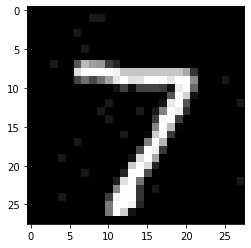

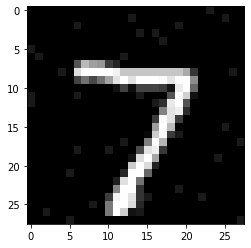

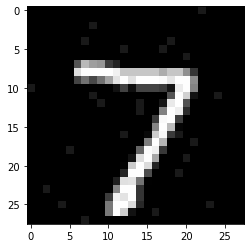

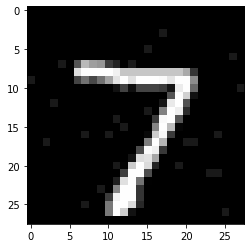

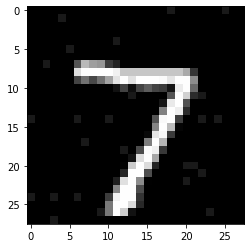

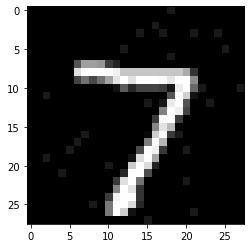

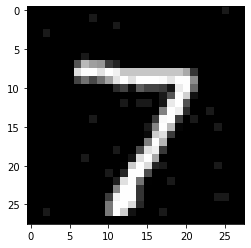

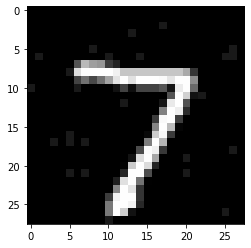

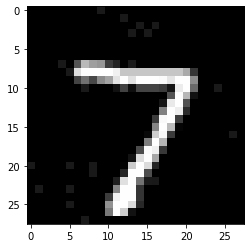

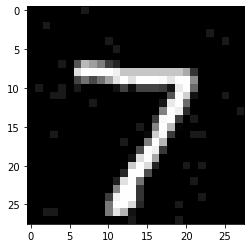

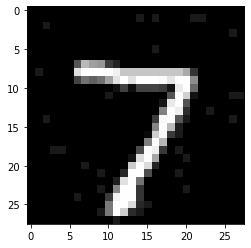

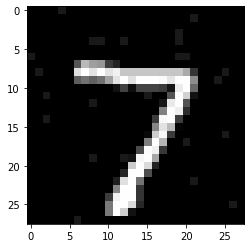

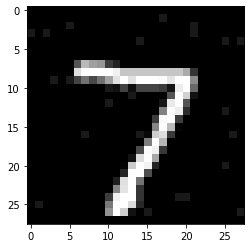

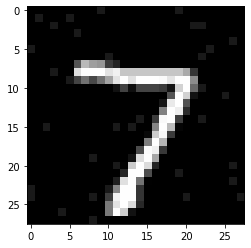

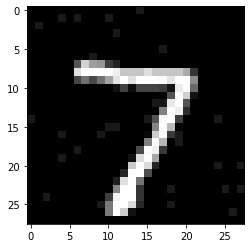

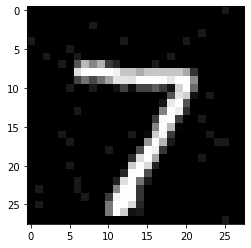

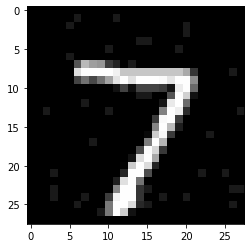

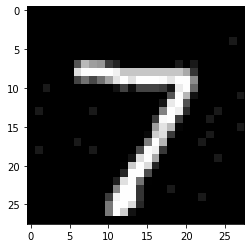

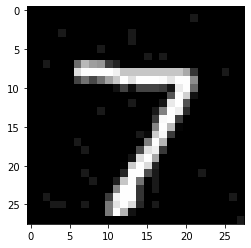

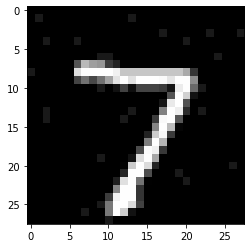

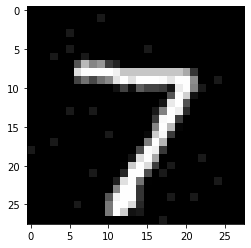

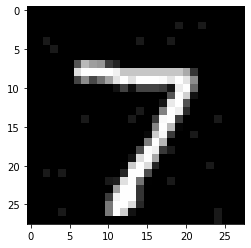

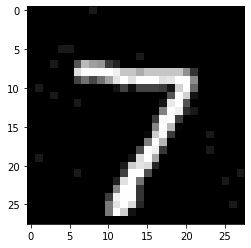

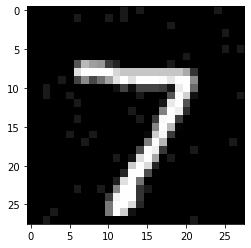

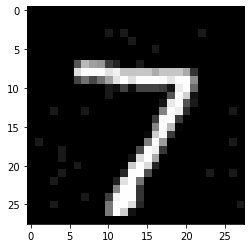

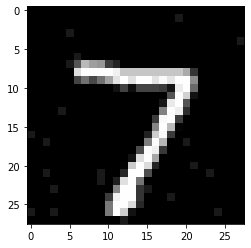

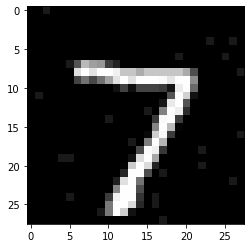

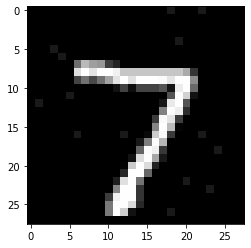

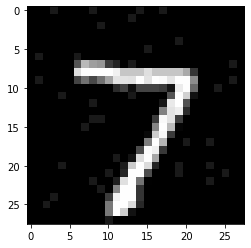

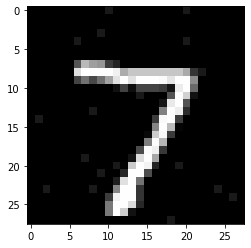

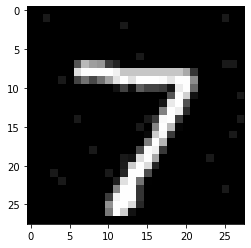

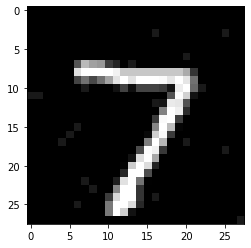

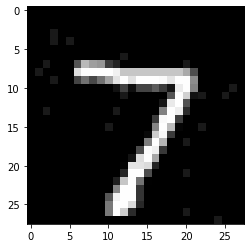

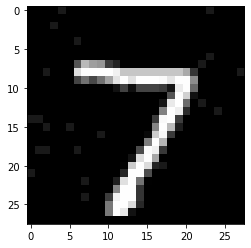

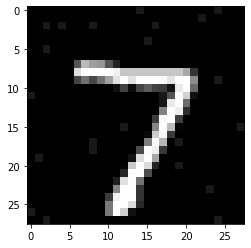

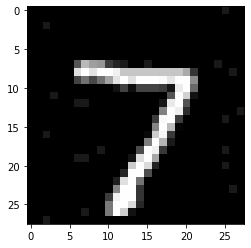

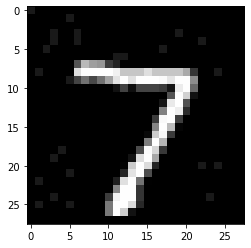

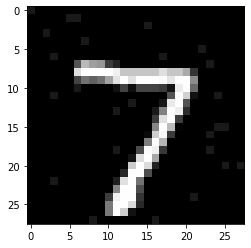

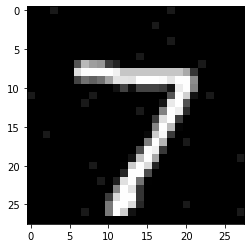

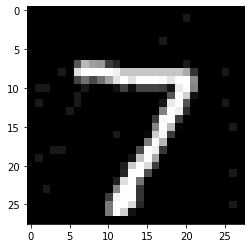

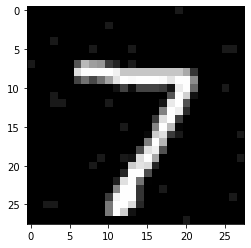

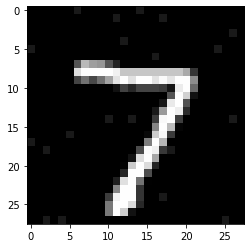

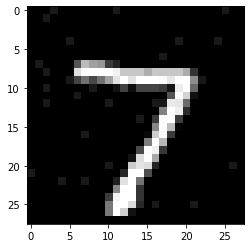

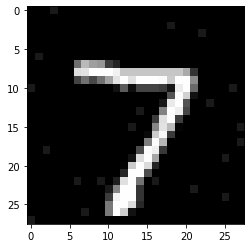

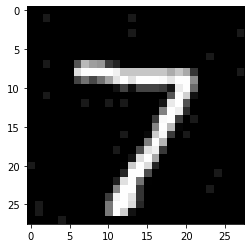

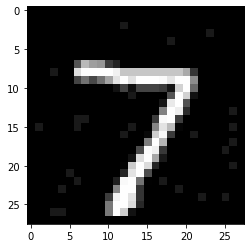

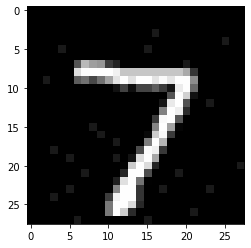

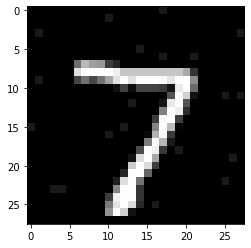

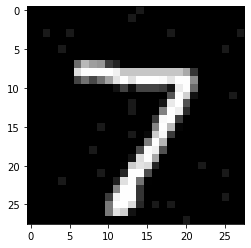

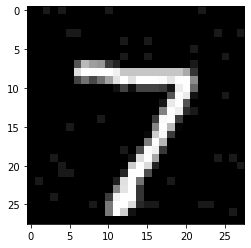

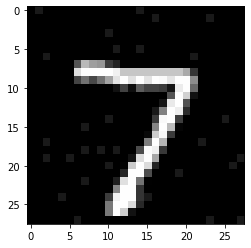

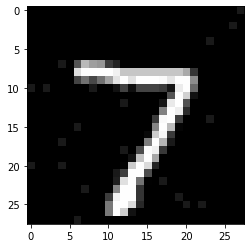

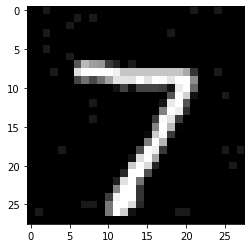

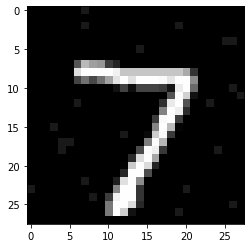

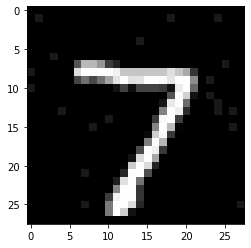

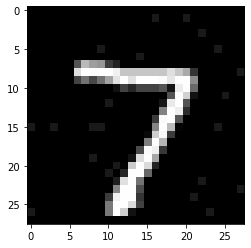

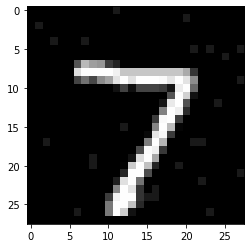

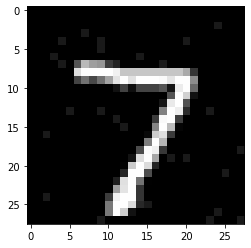

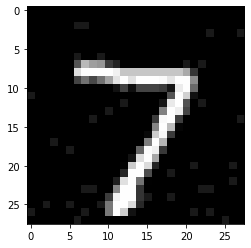

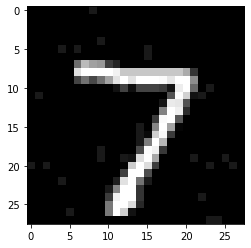

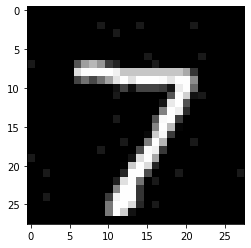

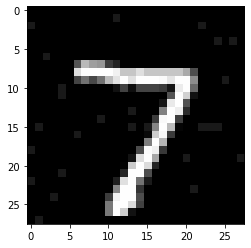

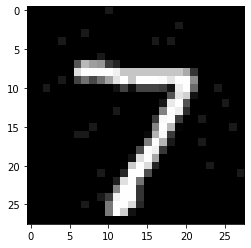

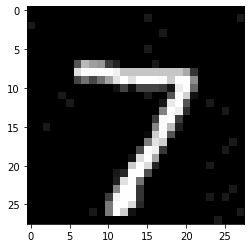

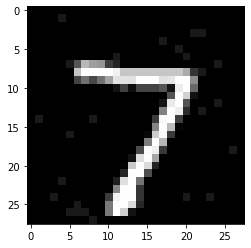

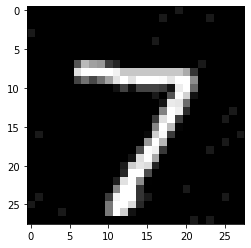

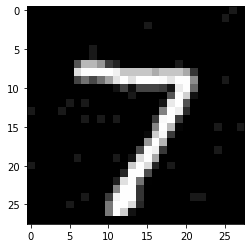

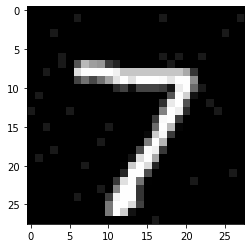

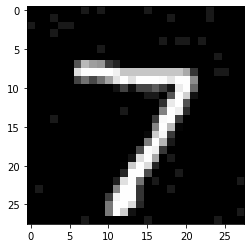

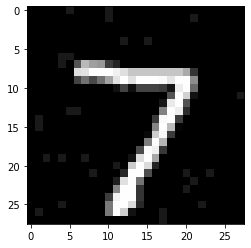

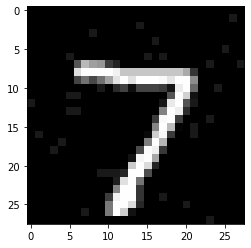

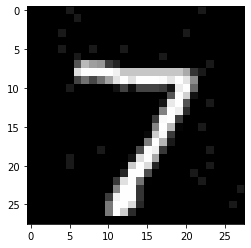

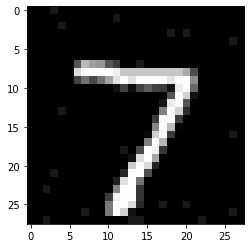

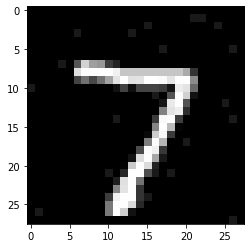

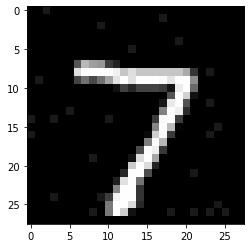

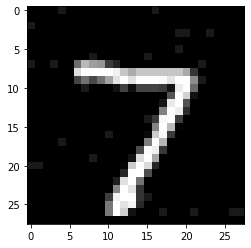

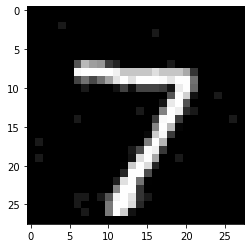

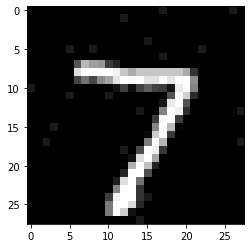

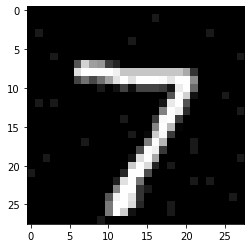

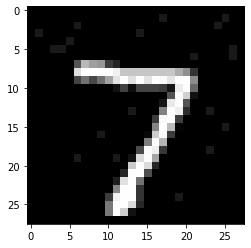

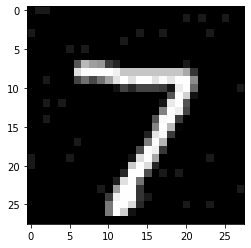

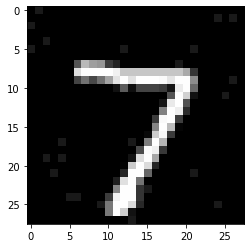

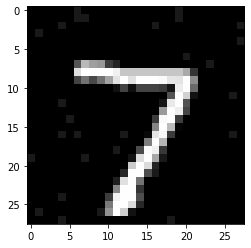

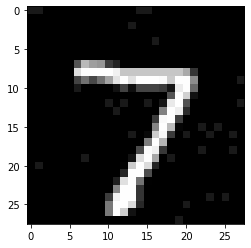

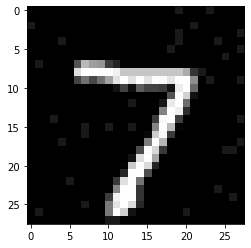

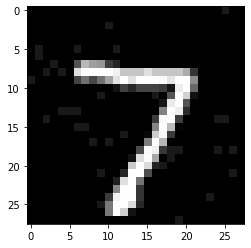

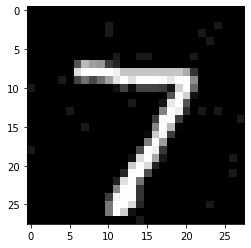

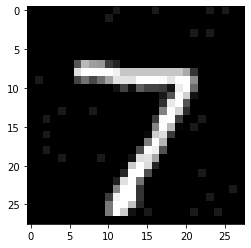

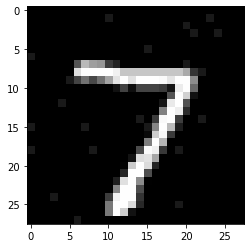

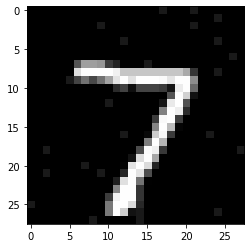

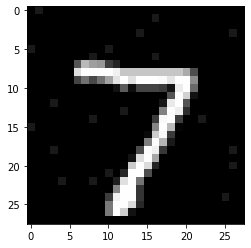

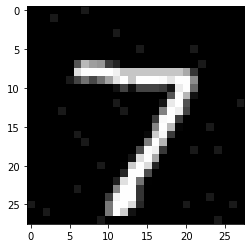

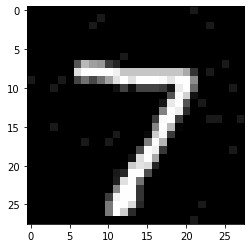

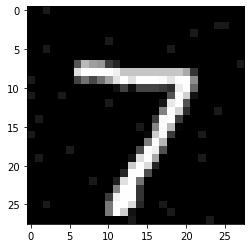

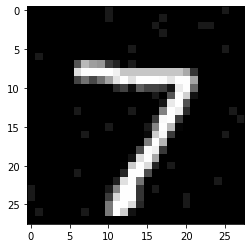

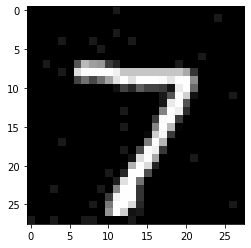

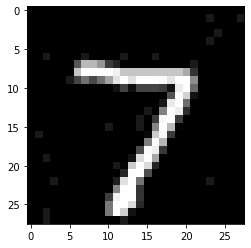

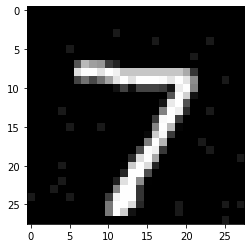

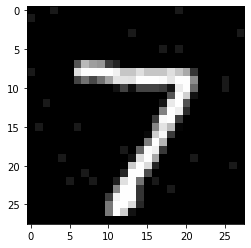

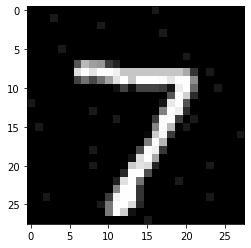

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [5]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [6]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [7]:
x_train = x_train / 255
x_test = x_test / 255 

In [8]:
model = load_model('mnist_model.h5')

In [9]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [10]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            Db[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Db ","最优值：", Func(Db),"扰动程度：",Dis(Db))
            best[:] = Db[:]
            if Func(best) > 0.5:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= 0.5:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")        
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= F:
                print("Resume")
                if D <= 5.0:
                    D += 0.3 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            Fb[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Fb ","最优值：", Func(Fb),"扰动程度：",Dis(Fb))
            best[:] = Fb[:]
            if Func(best) > 0.5:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Fb[:]
            
            if Func(BEST_X) <= 0.5:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")         
            if s == 1:
                best[:] = Fb[:]
            
            if Dis(BEST_X) <= D:
                print("Attack")
                if F > 0.3:
                    F -= 0.05
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 5000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.9   #置信度参数
D = 2.7   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "Attack")
re = Re(cond, "Resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
Db = np.zeros(L)
Fb = np.zeros(L)
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()

Attack
最优值： 0.9967527 扰动程度： 0.3430253364090736 代数： 1
best  最优值： 0.9967527 扰动程度： 0.3430253364090736
 
最优值： 0.996609 扰动程度： 0.3276939863744716 代数： 2
best  最优值： 0.996609 扰动程度： 0.3276939863744716
 
最优值： 0.99659145 扰动程度： 0.3300194316023013 代数： 3
best  最优值： 0.99659145 扰动程度： 0.3300194316023013
 
最优值： 0.9963995 扰动程度： 0.296834091264139 代数： 4
best  最优值： 0.9963995 扰动程度： 0.296834091264139
 
最优值： 0.9963354 扰动程度： 0.29908394103654384 代数： 5
best  最优值： 0.9963354 扰动程度： 0.29908394103654384
 
最优值： 0.99624926 扰动程度： 0.3148118794517784 代数： 6
best  最优值： 0.99624926 扰动程度： 0.3148118794517784
 
最优值： 0.9959186 扰动程度： 0.4048789397975255 代数： 7
best  最优值： 0.9959186 扰动程度： 0.4048789397975255
 
最优值： 0.9958742 扰动程度： 0.42122594379527634 代数： 8
best  最优值： 0.9958742 扰动程度： 0.42122594379527634
 
最优值： 0.99588215 扰动程度： 0.42550864988110654 代数： 9
best  最优值： 0.99588215 扰动程度： 0.42550864988110654
 
最优值： 0.9957729 扰动程度： 0.44304792224951783 代数： 10
best  最优值： 0.9957729 扰动程度： 0.44304792224951783
 
最优值： 0.9957546 扰动程度： 0.43684147766328474 代

最优值： 0.963137 扰动程度： 2.5070038795958967 代数： 88
best  最优值： 0.963137 扰动程度： 2.5070038795958967
 
最优值： 0.9626904 扰动程度： 2.423033386630165 代数： 89
best  最优值： 0.9626904 扰动程度： 2.423033386630165
 
最优值： 0.9619355 扰动程度： 2.46084793726904 代数： 90
best  最优值： 0.9619355 扰动程度： 2.46084793726904
 
最优值： 0.9608561 扰动程度： 2.526608788729781 代数： 91
best  最优值： 0.9608561 扰动程度： 2.526608788729781
 
最优值： 0.9608575 扰动程度： 2.6006240431708814 代数： 92
best  最优值： 0.9608575 扰动程度： 2.6006240431708814
 
最优值： 0.9569669 扰动程度： 2.6430064345636475 代数： 93
best  最优值： 0.9569669 扰动程度： 2.6430064345636475
 
最优值： 0.9565627 扰动程度： 2.6578868066532277 代数： 94
best  最优值： 0.9565627 扰动程度： 2.6578868066532277
 
最优值： 0.95559275 扰动程度： 2.7161608974698748 代数： 95
best  最优值： 0.95559275 扰动程度： 2.7161608974698748
 
最优值： 0.9546336 扰动程度： 2.7306586128377845 代数： 96
best  最优值： 0.9546336 扰动程度： 2.7306586128377845
 
最优值： 0.9541001 扰动程度： 2.7366621743633113 代数： 97
best  最优值： 0.9541001 扰动程度： 2.7366621743633113
 
最优值： 0.9527066 扰动程度： 2.7241752499613123 代数： 98
best  最优值： 

最优值： 0.9002331 扰动程度： 3.2750766845315518 代数： 174
best  最优值： 0.9002331 扰动程度： 3.2750766845315518
 
Attack
最优值： 0.8995992 扰动程度： 3.273295282659834 代数： 175
best  最优值： 0.8995992 扰动程度： 3.273295282659834
 
最优值： 0.8979112 扰动程度： 3.298158654805539 代数： 176
best  最优值： 0.8979112 扰动程度： 3.298158654805539
 
最优值： 0.89843225 扰动程度： 3.280833294333884 代数： 177
best  最优值： 0.89843225 扰动程度： 3.280833294333884
 
最优值： 0.8988958 扰动程度： 3.2870744977137725 代数： 178
best  最优值： 0.8988958 扰动程度： 3.2870744977137725
 
最优值： 0.89084923 扰动程度： 3.3699799112074422 代数： 179
best  最优值： 0.89084923 扰动程度： 3.3699799112074422
 
最优值： 0.89084923 扰动程度： 3.3699799112074422 代数： 180
best  最优值： 0.89084923 扰动程度： 3.3699799112074422
 
最优值： 0.89020175 扰动程度： 3.361765133481168 代数： 181
best  最优值： 0.89020175 扰动程度： 3.361765133481168
 
最优值： 0.88842785 扰动程度： 3.4524096746245205 代数： 182
best  最优值： 0.88842785 扰动程度： 3.4524096746245205
 
最优值： 0.8862692 扰动程度： 3.5040519078998718 代数： 183
best  最优值： 0.8862692 扰动程度： 3.5040519078998718
 
最优值： 0.8846349 扰动程度： 3.51567368

最优值： 0.7834334 扰动程度： 4.434063285001909 代数： 260
best  最优值： 0.7834334 扰动程度： 4.434063285001909
 
最优值： 0.7926925 扰动程度： 4.3500123685395815 代数： 261
best  最优值： 0.7926925 扰动程度： 4.3500123685395815
 
最优值： 0.8019011 扰动程度： 4.2698084553415026 代数： 262
best  最优值： 0.8019011 扰动程度： 4.2698084553415026
 
最优值： 0.8109165 扰动程度： 4.145648029352739 代数： 263
best  最优值： 0.8109165 扰动程度： 4.145648029352739
 
最优值： 0.8119086 扰动程度： 4.119798953401479 代数： 264
best  最优值： 0.8119086 扰动程度： 4.119798953401479
 
最优值： 0.8201697 扰动程度： 4.037514518469924 代数： 265
best  最优值： 0.8201697 扰动程度： 4.037514518469924
 
最优值： 0.81921655 扰动程度： 4.025501792071733 代数： 266
best  最优值： 0.81921655 扰动程度： 4.025501792071733
 
最优值： 0.8281971 扰动程度： 3.937178391810065 代数： 267
best  最优值： 0.8281971 扰动程度： 3.937178391810065
 
最优值： 0.830695 扰动程度： 3.8398519580238863 代数： 268
best  最优值： 0.830695 扰动程度： 3.8398519580238863
 
Attack
最优值： 0.8305244 扰动程度： 3.834030267749886 代数： 269
best  最优值： 0.8305244 扰动程度： 3.834030267749886
 
最优值： 0.83091784 扰动程度： 3.8401199767371987 代数： 27

最优值： 0.6649691 扰动程度： 5.075553558044027 代数： 347
best  最优值： 0.6649691 扰动程度： 5.075553558044027
 
最优值： 0.6659826 扰动程度： 5.084783864952326 代数： 348
best  最优值： 0.6659826 扰动程度： 5.084783864952326
 
最优值： 0.67251617 扰动程度： 5.012970935707986 代数： 349
best  最优值： 0.67251617 扰动程度： 5.012970935707986
 
最优值： 0.67779326 扰动程度： 4.979375632776266 代数： 350
best  最优值： 0.67779326 扰动程度： 4.979375632776266
 
最优值： 0.6875193 扰动程度： 4.9420421707659745 代数： 351
best  最优值： 0.6875193 扰动程度： 4.9420421707659745
 
最优值： 0.6966321 扰动程度： 4.8528423354840236 代数： 352
best  最优值： 0.6966321 扰动程度： 4.8528423354840236
 
最优值： 0.7020278 扰动程度： 4.80779184064258 代数： 353
best  最优值： 0.7020278 扰动程度： 4.80779184064258
 
最优值： 0.7047236 扰动程度： 4.80986527501416 代数： 354
best  最优值： 0.7047236 扰动程度： 4.80986527501416
 
最优值： 0.7143631 扰动程度： 4.722047683328814 代数： 355
best  最优值： 0.7143631 扰动程度： 4.722047683328814
 
最优值： 0.71276367 扰动程度： 4.662797013322053 代数： 356
best  最优值： 0.71276367 扰动程度： 4.662797013322053
 
最优值： 0.71823543 扰动程度： 4.626058610642026 代数： 357
best  

最优值： 0.6202713 扰动程度： 5.241542695550095 代数： 434
best  最优值： 0.6202713 扰动程度： 5.241542695550095
 
最优值： 0.6253455 扰动程度： 5.229956277418442 代数： 435
best  最优值： 0.6253455 扰动程度： 5.229956277418442
 
最优值： 0.62848043 扰动程度： 5.161590928982231 代数： 436
best  最优值： 0.62848043 扰动程度： 5.161590928982231
 
最优值： 0.63196915 扰动程度： 5.129707304698255 代数： 437
best  最优值： 0.63196915 扰动程度： 5.129707304698255
 
最优值： 0.6370615 扰动程度： 5.115227414187084 代数： 438
best  最优值： 0.6370615 扰动程度： 5.115227414187084
 
最优值： 0.64060104 扰动程度： 5.102255627273325 代数： 439
best  最优值： 0.64060104 扰动程度： 5.102255627273325
 
最优值： 0.64318454 扰动程度： 5.070307308786618 代数： 440
best  最优值： 0.64318454 扰动程度： 5.070307308786618
 
Attack
最优值： 0.6282805 扰动程度： 5.147876988349058 代数： 441
best  最优值： 0.6282805 扰动程度： 5.147876988349058
 
最优值： 0.61990464 扰动程度： 5.193412652569944 代数： 442
best  最优值： 0.61990464 扰动程度： 5.193412652569944
 
最优值： 0.60861427 扰动程度： 5.2619646715113335 代数： 443
best  最优值： 0.60861427 扰动程度： 5.2619646715113335
 
最优值： 0.60260385 扰动程度： 5.272399244251005

最优值： 0.4425977 扰动程度： 6.213292075502149 代数： 571
 
最优值： 0.43826088 扰动程度： 6.267893174543906 代数： 572
 
最优值： 0.43264693 扰动程度： 6.333936487870811 代数： 573
 
最优值： 0.4224168 扰动程度： 6.428350726922833 代数： 574
 
最优值： 0.4144132 扰动程度： 6.451194374205952 代数： 575
 
最优值： 0.40814805 扰动程度： 6.54764520059144 代数： 576
 
最优值： 0.39762768 扰动程度： 6.610143481479534 代数： 577
 
Resume
最优值： 0.39350748 扰动程度： 6.633044218927043 代数： 578
 
最优值： 0.39097366 扰动程度： 6.664283269310669 代数： 579
 
最优值： 0.39654365 扰动程度： 6.614320166911469 代数： 580
 
最优值： 0.39620057 扰动程度： 6.616835941362572 代数： 581
 
最优值： 0.3973603 扰动程度： 6.645224825347294 代数： 582
 
最优值： 0.40334505 扰动程度： 6.576326296010817 代数： 583
 
最优值： 0.4016677 扰动程度： 6.595205704007528 代数： 584
 
最优值： 0.39965957 扰动程度： 6.610885397278169 代数： 585
 
最优值： 0.4143936 扰动程度： 6.45036995543699 代数： 586
 
最优值： 0.4215222 扰动程度： 6.302837214263233 代数： 587
 
最优值： 0.42466506 扰动程度： 6.285261088314759 代数： 588
 
最优值： 0.4337561 扰动程度： 6.260106940162282 代数： 589
 
最优值： 0.44147956 扰动程度： 6.11775087986841 代数： 590
 
最优值：

最优值： 0.31044036 扰动程度： 7.030086836780462 代数： 733
 
最优值： 0.3159352 扰动程度： 6.962064873835605 代数： 734
 
最优值： 0.32338896 扰动程度： 6.909615886094427 代数： 735
 
最优值： 0.32781908 扰动程度： 6.857130937826173 代数： 736
 
最优值： 0.3364969 扰动程度： 6.824000790516296 代数： 737
 
最优值： 0.34506944 扰动程度： 6.689380339181636 代数： 738
 
最优值： 0.34753948 扰动程度： 6.58735803754559 代数： 739
 
最优值： 0.3529572 扰动程度： 6.5421422055205625 代数： 740
 
最优值： 0.36148983 扰动程度： 6.53191883773302 代数： 741
 
最优值： 0.35878864 扰动程度： 6.4890938664099025 代数： 742
 
最优值： 0.36090574 扰动程度： 6.474905525980995 代数： 743
 
最优值： 0.3699877 扰动程度： 6.422777115608561 代数： 744
 
最优值： 0.37004337 扰动程度： 6.4307744066785295 代数： 745
 
最优值： 0.37411878 扰动程度： 6.381581115360993 代数： 746
 
最优值： 0.38068235 扰动程度： 6.331187918979725 代数： 747
 
最优值： 0.37963223 扰动程度： 6.348511137280643 代数： 748
 
最优值： 0.38501117 扰动程度： 6.354409354289116 代数： 749
 
最优值： 0.3934645 扰动程度： 6.203810135169951 代数： 750
 
最优值： 0.3934704 扰动程度： 6.20354832803584 代数： 751
 
最优值： 0.3996745 扰动程度： 6.1704678029675915 代数： 752
 
最优值： 0

最优值： 0.31862888 扰动程度： 6.653219610997166 代数： 896
 
最优值： 0.3131343 扰动程度： 6.700552096742911 代数： 897
 
最优值： 0.31771043 扰动程度： 6.650733750918468 代数： 898
 
最优值： 0.3135205 扰动程度： 6.69925331313392 代数： 899
 
最优值： 0.31444624 扰动程度： 6.700766849305428 代数： 900
 
最优值： 0.3007952 扰动程度： 6.79345264772016 代数： 901
 
最优值： 0.30026785 扰动程度： 6.868709571027189 代数： 902
 
最优值： 0.2987099 扰动程度： 6.889204752598712 代数： 903
 
Resume
最优值： 0.30625227 扰动程度： 6.736362655556388 代数： 904
 
最优值： 0.3130607 扰动程度： 6.664814333635397 代数： 905
 
最优值： 0.32145226 扰动程度： 6.604185937295448 代数： 906
 
最优值： 0.33024994 扰动程度： 6.511729355620641 代数： 907
 
最优值： 0.33633947 扰动程度： 6.470477550570658 代数： 908
 
最优值： 0.34264907 扰动程度： 6.363308495301272 代数： 909
 
最优值： 0.34470224 扰动程度： 6.375191783219873 代数： 910
 
最优值： 0.3463405 扰动程度： 6.293567725229652 代数： 911
 
最优值： 0.35040525 扰动程度： 6.269783595999595 代数： 912
 
最优值： 0.35964713 扰动程度： 6.23966294675891 代数： 913
 
最优值： 0.36591625 扰动程度： 6.153798541137438 代数： 914
 
最优值： 0.3660046 扰动程度： 6.128517930523323 代数： 915
 
最优值

最优值： 0.39461753 扰动程度： 5.779290874840685 代数： 1057
 
最优值： 0.40165707 扰动程度： 5.745794441142018 代数： 1058
 
最优值： 0.41126797 扰动程度： 5.6987487905193905 代数： 1059
 
最优值： 0.41988155 扰动程度： 5.615144078967967 代数： 1060
 
最优值： 0.42312503 扰动程度： 5.580232971090031 代数： 1061
 
最优值： 0.42709878 扰动程度： 5.578049084363001 代数： 1062
 
最优值： 0.43407887 扰动程度： 5.52621879320443 代数： 1063
 
最优值： 0.43890238 扰动程度： 5.507457261870429 代数： 1064
 
最优值： 0.4474649 扰动程度： 5.431048953717655 代数： 1065
 
最优值： 0.45240825 扰动程度： 5.398023326085184 代数： 1066
 
最优值： 0.4603793 扰动程度： 5.322522594521986 代数： 1067
 
最优值： 0.4611335 扰动程度： 5.317570784805534 代数： 1068
 
最优值： 0.46650442 扰动程度： 5.33828544855032 代数： 1069
 
最优值： 0.46725845 扰动程度： 5.276463540628337 代数： 1070
 
最优值： 0.47488537 扰动程度： 5.250590651148449 代数： 1071
 
最优值： 0.48150834 扰动程度： 5.228296575256325 代数： 1072
 
最优值： 0.48367384 扰动程度： 5.206210448208801 代数： 1073
 
最优值： 0.4914283 扰动程度： 5.155856379804407 代数： 1074
 
最优值： 0.4943117 扰动程度： 5.144606754238808 代数： 1075
 
最优值： 0.50392735 扰动程度： 5.1197873799222

最优值： 0.34398884 扰动程度： 6.058450803341206 代数： 1217
 
最优值： 0.33545354 扰动程度： 6.138191190953641 代数： 1218
 
最优值： 0.32763538 扰动程度： 6.22120413043114 代数： 1219
 
最优值： 0.31339338 扰动程度： 6.237044122091324 代数： 1220
 
最优值： 0.310852 扰动程度： 6.269237648449008 代数： 1221
 
最优值： 0.30698666 扰动程度： 6.324238543743633 代数： 1222
 
最优值： 0.30553302 扰动程度： 6.300973600242266 代数： 1223
 
最优值： 0.302815 扰动程度： 6.31729924835855 代数： 1224
 
最优值： 0.29627386 扰动程度： 6.385123582576159 代数： 1225
 
Resume
最优值： 0.301429 扰动程度： 6.336919579018643 代数： 1226
 
最优值： 0.31127095 扰动程度： 6.29811675722585 代数： 1227
 
最优值： 0.31555638 扰动程度： 6.238154513551223 代数： 1228
 
最优值： 0.3236249 扰动程度： 6.102264430049288 代数： 1229
 
最优值： 0.32465708 扰动程度： 6.092809435353174 代数： 1230
 
最优值： 0.32561603 扰动程度： 6.090820177462663 代数： 1231
 
最优值： 0.3320443 扰动程度： 6.028354086798169 代数： 1232
 
最优值： 0.33352244 扰动程度： 6.015638679496078 代数： 1233
 
最优值： 0.3430707 扰动程度： 5.951726217299794 代数： 1234
 
最优值： 0.34688717 扰动程度： 5.929177860037856 代数： 1235
 
最优值： 0.34991 扰动程度： 5.926193511413063

最优值： 0.3484045 扰动程度： 5.892351658214143 代数： 1377
 
最优值： 0.35584712 扰动程度： 5.80665045365375 代数： 1378
 
最优值： 0.360746 扰动程度： 5.754283755613828 代数： 1379
 
最优值： 0.35881758 扰动程度： 5.767739175140305 代数： 1380
 
最优值： 0.36352253 扰动程度： 5.740870541230236 代数： 1381
 
最优值： 0.37271535 扰动程度： 5.7015651411384125 代数： 1382
 
最优值： 0.37718987 扰动程度： 5.6130038375821805 代数： 1383
 
最优值： 0.37873057 扰动程度： 5.60597304768873 代数： 1384
 
最优值： 0.3862208 扰动程度： 5.5708871685797385 代数： 1385
 
最优值： 0.3860533 扰动程度： 5.572942528675662 代数： 1386
 
最优值： 0.38478604 扰动程度： 5.559100734996875 代数： 1387
 
最优值： 0.40028757 扰动程度： 5.501809546202097 代数： 1388
 
最优值： 0.40756205 扰动程度： 5.520735676085911 代数： 1389
 
最优值： 0.4131068 扰动程度： 5.422902887098971 代数： 1390
 
最优值： 0.4212905 扰动程度： 5.365035371797738 代数： 1391
 
最优值： 0.42189896 扰动程度： 5.355501611689072 代数： 1392
 
最优值： 0.42349494 扰动程度： 5.349781397384874 代数： 1393
 
最优值： 0.42936936 扰动程度： 5.32727237402438 代数： 1394
 
最优值： 0.45356792 扰动程度： 5.210628047172041 代数： 1395
 
最优值： 0.45614213 扰动程度： 5.17942368378272

最优值： 0.37676784 扰动程度： 5.51885321657779 代数： 1537
 
最优值： 0.36482722 扰动程度： 5.577854642811411 代数： 1538
 
最优值： 0.35348886 扰动程度： 5.6682229409351566 代数： 1539
 
最优值： 0.35819364 扰动程度： 5.646090506144294 代数： 1540
 
最优值： 0.3419147 扰动程度： 5.7328400103670765 代数： 1541
 
最优值： 0.3407068 扰动程度： 5.783010637714407 代数： 1542
 
最优值： 0.337566 扰动程度： 5.823815069174338 代数： 1543
 
最优值： 0.3298806 扰动程度： 5.820956019783532 代数： 1544
 
最优值： 0.32248047 扰动程度： 5.865057937631289 代数： 1545
 
最优值： 0.32048005 扰动程度： 5.87916626598891 代数： 1546
 
最优值： 0.3191671 扰动程度： 5.942676817184734 代数： 1547
 
最优值： 0.3072966 扰动程度： 6.023369769358459 代数： 1548
 
最优值： 0.29290208 扰动程度： 6.091711551816336 代数： 1549
 
Resume
最优值： 0.29245982 扰动程度： 6.0999167793405125 代数： 1550
 
最优值： 0.29021394 扰动程度： 6.113359927507104 代数： 1551
 
最优值： 0.29170266 扰动程度： 6.106853164371123 代数： 1552
 
最优值： 0.28849578 扰动程度： 6.1219329622326555 代数： 1553
 
最优值： 0.29213148 扰动程度： 6.107107079492843 代数： 1554
 
最优值： 0.2903656 扰动程度： 6.121361327697746 代数： 1555
 
最优值： 0.29397723 扰动程度： 6.087046

最优值： 0.41316763 扰动程度： 5.153162275309388 代数： 1696
 
最优值： 0.40438867 扰动程度： 5.247913789148304 代数： 1697
 
最优值： 0.39069262 扰动程度： 5.322706989942149 代数： 1698
 
最优值： 0.37255418 扰动程度： 5.408529375487893 代数： 1699
 
最优值： 0.3641288 扰动程度： 5.450890533040555 代数： 1700
best  最优值： 0.3641288 扰动程度： 5.450890533040555
 
最优值： 0.35416096 扰动程度： 5.52195027350244 代数： 1701
 
最优值： 0.35231188 扰动程度： 5.608389780782238 代数： 1702
 
最优值： 0.33735493 扰动程度： 5.661468533684871 代数： 1703
 
最优值： 0.33162215 扰动程度： 5.705638116594444 代数： 1704
 
最优值： 0.31479016 扰动程度： 5.799009462158574 代数： 1705
 
最优值： 0.3111098 扰动程度： 5.827154009978899 代数： 1706
 
最优值： 0.31281355 扰动程度： 5.8796104636648 代数： 1707
 
最优值： 0.2942402 扰动程度： 5.9634443976493205 代数： 1708
 
Resume
最优值： 0.2921522 扰动程度： 5.983543513164504 代数： 1709
 
最优值： 0.29335597 扰动程度： 5.969894027996511 代数： 1710
 
最优值： 0.29600105 扰动程度： 5.96427630561233 代数： 1711
 
最优值： 0.29713765 扰动程度： 5.948871457063194 代数： 1712
 
最优值： 0.30723298 扰动程度： 5.874880408093807 代数： 1713
 
最优值： 0.31735173 扰动程度： 5.7863958299365

最优值： 0.3459897 扰动程度： 5.433979424740937 代数： 1853
 
最优值： 0.35388064 扰动程度： 5.424562230992068 代数： 1854
 
最优值： 0.36332065 扰动程度： 5.371652799202973 代数： 1855
 
最优值： 0.37060767 扰动程度： 5.3213512796059375 代数： 1856
 
最优值： 0.37048486 扰动程度： 5.3194236898531 代数： 1857
 
最优值： 0.38023624 扰动程度： 5.278739589098788 代数： 1858
 
最优值： 0.38708943 扰动程度： 5.226872095378789 代数： 1859
 
最优值： 0.39435586 扰动程度： 5.196810166211569 代数： 1860
 
最优值： 0.40017152 扰动程度： 5.156827068818084 代数： 1861
 
最优值： 0.40422374 扰动程度： 5.088558214675316 代数： 1862
 
Attack
最优值： 0.40675238 扰动程度： 5.076360378645885 代数： 1863
 
最优值： 0.40477103 扰动程度： 5.0847560602041115 代数： 1864
 
最优值： 0.39518952 扰动程度： 5.173005943198493 代数： 1865
 
最优值： 0.36966193 扰动程度： 5.326805184173547 代数： 1866
 
最优值： 0.34833452 扰动程度： 5.425223901701609 代数： 1867
 
最优值： 0.3441278 扰动程度： 5.485915260471119 代数： 1868
 
最优值： 0.33227688 扰动程度： 5.574048429863433 代数： 1869
 
最优值： 0.32662576 扰动程度： 5.6457064327418545 代数： 1870
 
最优值： 0.3137593 扰动程度： 5.707893964304938 代数： 1871
 
最优值： 0.30400375 扰动程度： 5.80

最优值： 0.3576214 扰动程度： 5.30938793926438 代数： 2012
 
最优值： 0.35962036 扰动程度： 5.28217118351176 代数： 2013
 
最优值： 0.3684279 扰动程度： 5.272964428051531 代数： 2014
 
最优值： 0.37702847 扰动程度： 5.191713722413978 代数： 2015
 
最优值： 0.3858357 扰动程度： 5.183238376942762 代数： 2016
 
最优值： 0.3928428 扰动程度： 5.124290463208776 代数： 2017
 
最优值： 0.39106613 扰动程度： 5.139188979930116 代数： 2018
 
最优值： 0.39808846 扰动程度： 5.026928590494527 代数： 2019
 
Attack
最优值： 0.4046245 扰动程度： 4.997686378322182 代数： 2020
 
最优值： 0.39838976 扰动程度： 5.024194155300463 代数： 2021
 
最优值： 0.3929339 扰动程度： 5.118831445880929 代数： 2022
 
最优值： 0.36371446 扰动程度： 5.21473713010838 代数： 2023
 
最优值： 0.36183923 扰动程度： 5.299086439196686 代数： 2024
 
最优值： 0.34856638 扰动程度： 5.316384781296182 代数： 2025
best  最优值： 0.34856638 扰动程度： 5.316384781296182
 
最优值： 0.34528512 扰动程度： 5.3968852628119715 代数： 2026
 
最优值： 0.33682743 扰动程度： 5.478617834333548 代数： 2027
 
最优值： 0.32757095 扰动程度： 5.536579143041295 代数： 2028
 
最优值： 0.31564188 扰动程度： 5.628231719442572 代数： 2029
 
最优值： 0.30449495 扰动程度： 5.7217574737441

最优值： 0.34900668 扰动程度： 5.320317189464751 代数： 2171
 
最优值： 0.35769305 扰动程度： 5.260457546000134 代数： 2172
 
最优值： 0.36376747 扰动程度： 5.159371313665251 代数： 2173
 
最优值： 0.3667197 扰动程度： 5.14246074582238 代数： 2174
 
最优值： 0.3661525 扰动程度： 5.150748183860993 代数： 2175
 
最优值： 0.36714345 扰动程度： 5.142430515100667 代数： 2176
 
最优值： 0.3724648 扰动程度： 5.126861453191967 代数： 2177
 
最优值： 0.3795751 扰动程度： 5.092524331895164 代数： 2178
 
Attack
最优值： 0.3658742 扰动程度： 5.184220407255447 代数： 2179
 
最优值： 0.35594824 扰动程度： 5.281875507195484 代数： 2180
 
最优值： 0.33113736 扰动程度： 5.366337114444706 代数： 2181
 
最优值： 0.3294576 扰动程度： 5.434160870816973 代数： 2182
 
最优值： 0.32638282 扰动程度： 5.493449422584865 代数： 2183
 
最优值： 0.31581542 扰动程度： 5.577885492641123 代数： 2184
 
最优值： 0.29620656 扰动程度： 5.656621212177683 代数： 2185
 
Resume
最优值： 0.2976953 扰动程度： 5.644101834011688 代数： 2186
 
最优值： 0.29535457 扰动程度： 5.648502597932337 代数： 2187
 
最优值： 0.29284158 扰动程度： 5.66220769699267 代数： 2188
 
最优值： 0.29647428 扰动程度： 5.658642927553053 代数： 2189
 
最优值： 0.29757273 扰动程度： 5.64

最优值： 0.33204085 扰动程度： 5.339907773862904 代数： 2329
 
最优值： 0.32301614 扰动程度： 5.397599388667317 代数： 2330
 
最优值： 0.3124777 扰动程度： 5.4898937102519945 代数： 2331
 
最优值： 0.3033378 扰动程度： 5.551700916442994 代数： 2332
 
最优值： 0.29937786 扰动程度： 5.589279720119721 代数： 2333
 
Resume
最优值： 0.29625028 扰动程度： 5.613955869014134 代数： 2334
 
最优值： 0.300785 扰动程度： 5.586648593345223 代数： 2335
 
最优值： 0.29907522 扰动程度： 5.599897782905016 代数： 2336
 
最优值： 0.30313927 扰动程度： 5.5529728724615754 代数： 2337
 
最优值： 0.3077519 扰动程度： 5.526277760272007 代数： 2338
 
最优值： 0.3153543 扰动程度： 5.458553980640187 代数： 2339
 
最优值： 0.32481378 扰动程度： 5.3938596492657185 代数： 2340
 
最优值： 0.3337005 扰动程度： 5.330016325572112 代数： 2341
 
最优值： 0.3408008 扰动程度： 5.264368988236176 代数： 2342
 
最优值： 0.34917805 扰动程度： 5.21467114395416 代数： 2343
 
最优值： 0.357105 扰动程度： 5.193010365616324 代数： 2344
 
最优值： 0.36219174 扰动程度： 5.144776124218093 代数： 2345
 
最优值： 0.37106985 扰动程度： 5.1093854516844015 代数： 2346
 
最优值： 0.37985545 扰动程度： 5.0562001760687725 代数： 2347
 
Attack
最优值： 0.36809313 扰动程度： 5

最优值： 0.30208194 扰动程度： 5.525270683967226 代数： 2487
 
最优值： 0.29105955 扰动程度： 5.588509340478382 代数： 2488
 
Resume
最优值： 0.29339144 扰动程度： 5.574233376191716 代数： 2489
 
最优值： 0.2977327 扰动程度： 5.543141977706409 代数： 2490
 
最优值： 0.3037628 扰动程度： 5.453384309859333 代数： 2491
 
最优值： 0.3103737 扰动程度： 5.362768610396716 代数： 2492
 
最优值： 0.3157348 扰动程度： 5.337637503364521 代数： 2493
 
最优值： 0.3238201 扰动程度： 5.3154785568937815 代数： 2494
 
最优值： 0.33251873 扰动程度： 5.2491006936032605 代数： 2495
best  最优值： 0.33251873 扰动程度： 5.2491006936032605
 
最优值： 0.33443552 扰动程度： 5.224958732001239 代数： 2496
 
最优值： 0.33839718 扰动程度： 5.186164793654689 代数： 2497
 
最优值： 0.34814927 扰动程度： 5.16179720334293 代数： 2498
 
最优值： 0.3554165 扰动程度： 5.13641688128758 代数： 2499
 
最优值： 0.363784 扰动程度： 5.107719580838014 代数： 2500
 
最优值： 0.36828962 扰动程度： 5.034488220233927 代数： 2501
 
Attack
最优值： 0.35115185 扰动程度： 5.133818077003631 代数： 2502
 
最优值： 0.34167334 扰动程度： 5.1860140710565945 代数： 2503
 
最优值： 0.3313937 扰动程度： 5.276374062852286 代数： 2504
 
最优值： 0.32193413 扰动程度： 5.35990

最优值： 0.3232703 扰动程度： 5.252593516250253 代数： 2645
 
最优值： 0.33071646 扰动程度： 5.195022058940654 代数： 2646
 
最优值： 0.3348177 扰动程度： 5.185339057461028 代数： 2647
 
最优值： 0.33599994 扰动程度： 5.162449907769683 代数： 2648
 
最优值： 0.3404753 扰动程度： 5.139312450558889 代数： 2649
 
最优值： 0.34773228 扰动程度： 5.104852699214164 代数： 2650
 
最优值： 0.3530729 扰动程度： 5.072832754315567 代数： 2651
 
Attack
最优值： 0.33926427 扰动程度： 5.148500991602707 代数： 2652
 
最优值： 0.32207063 扰动程度： 5.243268599127051 代数： 2653
best  最优值： 0.32207063 扰动程度： 5.243268599127051
 
最优值： 0.31367028 扰动程度： 5.327742495686345 代数： 2654
 
最优值： 0.30686948 扰动程度： 5.368876051390493 代数： 2655
 
最优值： 0.2989557 扰动程度： 5.439974165688209 代数： 2656
 
Resume
最优值： 0.30705887 扰动程度： 5.361585494812313 代数： 2657
 
最优值： 0.3157708 扰动程度： 5.329330722847349 代数： 2658
 
最优值： 0.322715 扰动程度： 5.2451594353747595 代数： 2659
 
最优值： 0.3223422 扰动程度： 5.2305108667864655 代数： 2660
 
最优值： 0.32607818 扰动程度： 5.222042196369552 代数： 2661
 
最优值： 0.33263892 扰动程度： 5.181407236728209 代数： 2662
 
最优值： 0.33344376 扰动程度： 5.17033

最优值： 0.33767518 扰动程度： 5.091135664000661 代数： 2801
 
Attack
最优值： 0.32378656 扰动程度： 5.1700197801754175 代数： 2802
 
最优值： 0.3136234 扰动程度： 5.253124996710108 代数： 2803
 
最优值： 0.30144376 扰动程度： 5.310329886084954 代数： 2804
 
最优值： 0.29500496 扰动程度： 5.391551040430818 代数： 2805
 
Resume
最优值： 0.3047389 扰动程度： 5.299078966220595 代数： 2806
 
最优值： 0.31390232 扰动程度： 5.255139343290697 代数： 2807
 
最优值： 0.32349968 扰动程度： 5.2011266277664445 代数： 2808
 
最优值： 0.33178425 扰动程度： 5.128179424086283 代数： 2809
 
最优值： 0.33791927 扰动程度： 5.064000066966514 代数： 2810
 
Attack
最优值： 0.3280659 扰动程度： 5.1575945786773145 代数： 2811
 
最优值： 0.31614745 扰动程度： 5.228743955664373 代数： 2812
 
最优值： 0.30455926 扰动程度： 5.274983419860358 代数： 2813
 
最优值： 0.3013484 扰动程度： 5.3461046417162965 代数： 2814
 
最优值： 0.29523125 扰动程度： 5.408373772978496 代数： 2815
 
Resume
最优值： 0.30257288 扰动程度： 5.3217596764569715 代数： 2816
 
最优值： 0.30839658 扰动程度： 5.274973901585343 代数： 2817
 
最优值： 0.31756002 扰动程度： 5.2364260064774895 代数： 2818
 
最优值： 0.32733858 扰动程度： 5.179522322386106 代数： 2819
 
最

最优值： 0.3136618 扰动程度： 5.197443837643196 代数： 2957
 
最优值： 0.32005566 扰动程度： 5.167012942609863 代数： 2958
 
最优值： 0.3381203 扰动程度： 5.053155448797378 代数： 2959
 
Attack
最优值： 0.31786707 扰动程度： 5.182064357095554 代数： 2960
 
最优值： 0.30263582 扰动程度： 5.261259097774589 代数： 2961
 
最优值： 0.2967977 扰动程度： 5.303224300977297 代数： 2962
 
Resume
最优值： 0.30422154 扰动程度： 5.243254164371831 代数： 2963
 
最优值： 0.3073578 扰动程度： 5.234369960181034 代数： 2964
 
最优值： 0.31693867 扰动程度： 5.1807145269752946 代数： 2965
 
最优值： 0.32419357 扰动程度： 5.135101283583219 代数： 2966
 
最优值： 0.3321418 扰动程度： 5.084823374252989 代数： 2967
 
Attack
最优值： 0.31031623 扰动程度： 5.22281742613583 代数： 2968
 
最优值： 0.29463166 扰动程度： 5.3156259168718005 代数： 2969
 
Resume
最优值： 0.30225405 扰动程度： 5.310027628465816 代数： 2970
 
最优值： 0.30997503 扰动程度： 5.22334605330853 代数： 2971
 
最优值： 0.31995076 扰动程度： 5.143025912432418 代数： 2972
 
最优值： 0.3283813 扰动程度： 5.1089475381974605 代数： 2973
 
最优值： 0.33750287 扰动程度： 5.050414943848753 代数： 2974
 
Attack
最优值： 0.31932202 扰动程度： 5.147497604569617 代数： 2975
 
最

最优值： 0.32295263 扰动程度： 5.09724653631782 代数： 3110
 
Attack
最优值： 0.3053066 扰动程度： 5.153737945344879 代数： 3111
 
最优值： 0.2980783 扰动程度： 5.239380141261556 代数： 3112
 
Resume
最优值： 0.30237183 扰动程度： 5.21085466222445 代数： 3113
 
最优值： 0.30876422 扰动程度： 5.173786062804719 代数： 3114
 
最优值： 0.31385946 扰动程度： 5.09052772115455 代数： 3115
 
Attack
最优值： 0.30275464 扰动程度： 5.187456671169767 代数： 3116
 
最优值： 0.29302853 扰动程度： 5.275177003688613 代数： 3117
 
Resume
最优值： 0.29987863 扰动程度： 5.233681359786958 代数： 3118
 
最优值： 0.30703476 扰动程度： 5.179096959190022 代数： 3119
 
最优值： 0.31700754 扰动程度： 5.132867259695476 代数： 3120
 
最优值： 0.3183405 扰动程度： 5.09621564045696 代数： 3121
 
Attack
最优值： 0.30368423 扰动程度： 5.188889371232606 代数： 3122
 
最优值： 0.28805578 扰动程度： 5.281889779333009 代数： 3123
 
Resume
最优值： 0.29241887 扰动程度： 5.258446555461506 代数： 3124
 
最优值： 0.29493704 扰动程度： 5.23828122208722 代数： 3125
 
最优值： 0.2988756 扰动程度： 5.218563509848082 代数： 3126
 
最优值： 0.3065408 扰动程度： 5.170046884205599 代数： 3127
 
最优值： 0.31242722 扰动程度： 5.129060618935264 代数： 3128
 

最优值： 0.300611 扰动程度： 5.145925915525183 代数： 3263
 
最优值： 0.3068599 扰动程度： 5.096229613940706 代数： 3264
 
Attack
最优值： 0.29460743 扰动程度： 5.189700998911922 代数： 3265
 
Resume
最优值： 0.3035325 扰动程度： 5.137525012727629 代数： 3266
 
最优值： 0.3133241 扰动程度： 5.096539542807752 代数： 3267
 
Attack
最优值： 0.29511437 扰动程度： 5.191375072413694 代数： 3268
 
Resume
最优值： 0.3014552 扰动程度： 5.142330056950265 代数： 3269
 
最优值： 0.30988237 扰动程度： 5.070869038443279 代数： 3270
 
Attack
最优值： 0.30082908 扰动程度： 5.1527719555858 代数： 3271
 
最优值： 0.28820047 扰动程度： 5.239924529116593 代数： 3272
 
Resume
最优值： 0.29632595 扰动程度： 5.1873107185152065 代数： 3273
 
最优值： 0.30608976 扰动程度： 5.127611961707726 代数： 3274
 
最优值： 0.31321126 扰动程度： 5.053838521959121 代数： 3275
 
Attack
最优值： 0.3006191 扰动程度： 5.141516533690491 代数： 3276
 
最优值： 0.28986138 扰动程度： 5.2083946896710165 代数： 3277
 
Resume
最优值： 0.29229984 扰动程度： 5.200725231211889 代数： 3278
 
最优值： 0.3015029 扰动程度： 5.158814645599036 代数： 3279
 
最优值： 0.30875972 扰动程度： 5.095199681495625 代数： 3280
 
Attack
最优值： 0.2947965 扰动程度： 5.1767

最优值： 0.29625496 扰动程度： 5.106963336873684 代数： 3408
 
最优值： 0.30597416 扰动程度： 5.062926387137467 代数： 3409
 
Attack
最优值： 0.28869283 扰动程度： 5.134418174413216 代数： 3410
 
Resume
最优值： 0.2972061 扰动程度： 5.100445546776562 代数： 3411
 
最优值： 0.30633688 扰动程度： 5.04392074451081 代数： 3412
 
Attack
最优值： 0.29135892 扰动程度： 5.133278649371539 代数： 3413
 
Resume
最优值： 0.30101174 扰动程度： 5.085521422649864 代数： 3414
 
Attack
最优值： 0.2892886 扰动程度： 5.168106832719354 代数： 3415
 
Resume
最优值： 0.29894128 扰动程度： 5.099333539863432 代数： 3416
 
Attack
最优值： 0.279283 扰动程度： 5.188108315326658 代数： 3417
 
Resume
最优值： 0.28850976 扰动程度： 5.137399599681432 代数： 3418
 
最优值： 0.29772303 扰动程度： 5.084737210929308 代数： 3419
 
Attack
最优值： 0.28124464 扰动程度： 5.173753455213668 代数： 3420
 
Resume
最优值： 0.29018563 扰动程度： 5.1236283325071135 代数： 3421
 
最优值： 0.3000003 扰动程度： 5.083506817675608 代数： 3422
 
Attack
最优值： 0.2860804 扰动程度： 5.1705107084776465 代数： 3423
 
Resume
最优值： 0.2958303 扰动程度： 5.116297762740109 代数： 3424
 
最优值： 0.30268478 扰动程度： 5.064122713942079 代数： 3425
 
Atta

最优值： 0.2851101 扰动程度： 5.0979817229987665 代数： 3553
 
Attack
最优值： 0.27111772 扰动程度： 5.190288995329555 代数： 3554
 
Resume
最优值： 0.27655283 扰动程度： 5.138849573792604 代数： 3555
 
最优值： 0.28604075 扰动程度： 5.0950189956532945 代数： 3556
 
Attack
最优值： 0.27485123 扰动程度： 5.188259917169192 代数： 3557
 
Resume
最优值： 0.28345045 扰动程度： 5.11919141254168 代数： 3558
 
最优值： 0.2921405 扰动程度： 5.064103143742532 代数： 3559
 
Attack
最优值： 0.27695563 扰动程度： 5.159805619882132 代数： 3560
 
Resume
最优值： 0.28567833 扰动程度： 5.106920126150433 代数： 3561
 
最优值： 0.2937115 扰动程度： 5.040113475494153 代数： 3562
 
Attack
最优值： 0.2767608 扰动程度： 5.134024087863038 代数： 3563
 
Resume
最优值： 0.28646386 扰动程度： 5.115353356279991 代数： 3564
 
最优值： 0.2940497 扰动程度： 5.034313201413324 代数： 3565
 
Attack
最优值： 0.2813268 扰动程度： 5.123570578556908 代数： 3566
 
Resume
最优值： 0.29025695 扰动程度： 5.0568768470566 代数： 3567
 
Attack
最优值： 0.27839497 扰动程度： 5.14258902421699 代数： 3568
 
Resume
最优值： 0.28810477 扰动程度： 5.064140591491889 代数： 3569
 
Attack
最优值： 0.2767009 扰动程度： 5.156565172287244 代数： 3570
 


最优值： 0.26607767 扰动程度： 5.1575049695383655 代数： 3697
 
Resume
最优值： 0.27463967 扰动程度： 5.105553542413662 代数： 3698
 
最优值： 0.2844841 扰动程度： 5.037796971686481 代数： 3699
 
Attack
最优值： 0.27262938 扰动程度： 5.131391186798115 代数： 3700
 
Resume
最优值： 0.2816497 扰动程度： 5.052078119816621 代数： 3701
 
Attack
最优值： 0.26775673 扰动程度： 5.1408871744583164 代数： 3702
 
Resume
最优值： 0.27770054 扰动程度： 5.096191901435573 代数： 3703
 
Attack
最优值： 0.26358798 扰动程度： 5.195846825468777 代数： 3704
 
Resume
最优值： 0.26979288 扰动程度： 5.1279899783681735 代数： 3705
 
最优值： 0.2760777 扰动程度： 5.0781164957932186 代数： 3706
 
Attack
最优值： 0.26451677 扰动程度： 5.160947359410444 代数： 3707
 
Resume
最优值： 0.27203435 扰动程度： 5.091138753910458 代数： 3708
 
Attack
最优值： 0.26420626 扰动程度： 5.190179002595729 代数： 3709
 
Resume
最优值： 0.27285212 扰动程度： 5.105210111367221 代数： 3710
 
最优值： 0.2823052 扰动程度： 5.052644496362055 代数： 3711
 
Attack
最优值： 0.26890546 扰动程度： 5.131044835401268 代数： 3712
 
Resume
最优值： 0.27568248 扰动程度： 5.0830698907611085 代数： 3713
 
Attack
最优值： 0.26398912 扰动程度： 5.1829842997

最优值： 0.27374125 扰动程度： 5.048060760466413 代数： 3843
 
Attack
最优值： 0.2610902 扰动程度： 5.142408060121327 代数： 3844
 
Resume
最优值： 0.2689194 扰动程度： 5.058043911915518 代数： 3845
 
Attack
最优值： 0.25429595 扰动程度： 5.1535055033767 代数： 3846
 
Resume
最优值： 0.2642203 扰动程度： 5.06969808999489 代数： 3847
 
Attack
最优值： 0.25704116 扰动程度： 5.147574258068228 代数： 3848
 
Resume
最优值： 0.26319513 扰动程度： 5.089861628099318 代数： 3849
 
Attack
最优值： 0.2554851 扰动程度： 5.182191330597308 代数： 3850
 
Resume
最优值： 0.26369795 扰动程度： 5.115200993811161 代数： 3851
 
最优值： 0.2696182 扰动程度： 5.041401822642436 代数： 3852
 
Attack
最优值： 0.2584086 扰动程度： 5.125547040768609 代数： 3853
 
Resume
最优值： 0.26762465 扰动程度： 5.065481798697517 代数： 3854
 
Attack
最优值： 0.25635505 扰动程度： 5.1567699245349745 代数： 3855
 
Resume
最优值： 0.2660125 扰动程度： 5.11632403553732 代数： 3856
 
最优值： 0.27462688 扰动程度： 5.0216400112058315 代数： 3857
best  最优值： 0.27462688 扰动程度： 5.0216400112058315
 
Attack
最优值： 0.26105297 扰动程度： 5.117923373587447 代数： 3858
 
Resume
最优值： 0.26954582 扰动程度： 5.058376269429903 代数： 3859

最优值： 0.23854828 扰动程度： 5.154823502165583 代数： 3987
 
Resume
最优值： 0.24815044 扰动程度： 5.094393923740959 代数： 3988
 
Attack
最优值： 0.2383459 扰动程度： 5.189079994979916 代数： 3989
 
Resume
最优值： 0.24627441 扰动程度： 5.100326039049021 代数： 3990
 
最优值： 0.2549935 扰动程度： 5.063140805993734 代数： 3991
 
Attack
最优值： 0.24096063 扰动程度： 5.150722481337376 代数： 3992
 
Resume
最优值： 0.24740091 扰动程度： 5.098399027467438 代数： 3993
 
Attack
最优值： 0.23737603 扰动程度： 5.190541051740453 代数： 3994
 
Resume
最优值： 0.24727444 扰动程度： 5.116001511968973 代数： 3995
 
最优值： 0.25691295 扰动程度： 5.060527681046721 代数： 3996
 
Attack
最优值： 0.24345274 扰动程度： 5.150415695380295 代数： 3997
 
Resume
最优值： 0.25303006 扰动程度： 5.073697675014165 代数： 3998
 
Attack
最优值： 0.23867784 扰动程度： 5.1538483045461945 代数： 3999
 
Resume
最优值： 0.24490474 扰动程度： 5.104350529588752 代数： 4000
 
最优值： 0.25224546 扰动程度： 5.05720880276909 代数： 4001
 
Attack
最优值： 0.24143809 扰动程度： 5.154911257992045 代数： 4002
 
Resume
最优值： 0.25098404 扰动程度： 5.080880131992792 代数： 4003
 
Attack
最优值： 0.23655817 扰动程度： 5.1692073992556

最优值： 0.2462433 扰动程度： 5.092609629608137 代数： 4132
 
Attack
最优值： 0.23201692 扰动程度： 5.179726519216351 代数： 4133
 
Resume
最优值： 0.24105929 扰动程度： 5.093855734048187 代数： 4134
 
Attack
最优值： 0.22933146 扰动程度： 5.181010795441858 代数： 4135
 
Resume
最优值： 0.23802875 扰动程度： 5.121461853324554 代数： 4136
 
最优值： 0.24509008 扰动程度： 5.055395163552961 代数： 4137
 
Attack
最优值： 0.22927345 扰动程度： 5.152894492592051 代数： 4138
 
Resume
最优值： 0.23794182 扰动程度： 5.0866399959198985 代数： 4139
 
Attack
最优值： 0.22894487 扰动程度： 5.1507227645651 代数： 4140
 
Resume
最优值： 0.23690863 扰动程度： 5.131672999230279 代数： 4141
 
最优值： 0.24570401 扰动程度： 5.078656350317954 代数： 4142
 
Attack
最优值： 0.22744492 扰动程度： 5.170712584580054 代数： 4143
 
Resume
最优值： 0.23397374 扰动程度： 5.132617225280953 代数： 4144
 
最优值： 0.24164648 扰动程度： 5.075435528424545 代数： 4145
 
Attack
最优值： 0.23004484 扰动程度： 5.158099648917098 代数： 4146
 
Resume
最优值： 0.23906085 扰动程度： 5.088374251813562 代数： 4147
 
Attack
最优值： 0.22847408 扰动程度： 5.1701600875505695 代数： 4148
 
Resume
最优值： 0.23762654 扰动程度： 5.104211646928

In [14]:
best

array([ 1.18257603e-03,  1.74373030e-01,  0.00000000e+00,  3.05509943e-02,
        1.65871306e-02,  0.00000000e+00,  1.07021416e-05,  4.82989952e-04,
        6.67843863e-03,  3.40436229e-02, -0.00000000e+00,  5.63211161e-03,
        0.00000000e+00,  0.00000000e+00,  2.13600264e-04,  8.82083483e-02,
        6.56202349e-04,  6.61939479e-02,  8.58190423e-04,  6.30814103e-02,
        0.00000000e+00,  2.27817948e-03,  1.57835362e-01,  0.00000000e+00,
        3.14818110e-03,  2.90957838e-04,  0.00000000e+00,  0.00000000e+00,
        8.05110809e-03,  0.00000000e+00,  2.35819499e-03,  1.57826975e-02,
        0.00000000e+00,  5.11866670e-02,  1.46485830e-04,  0.00000000e+00,
        3.83825598e-04,  0.00000000e+00,  4.89311281e-02,  0.00000000e+00,
        1.78328173e-02,  2.63370605e-02,  1.94341745e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.13653240e-02,
        0.00000000e+00,  3.07171565e-02,  0.00000000e+00,  4.58469081e-03,
        0.00000000e+00, -

In [15]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.27359915 扰动程度： 5.020003659856384


In [10]:
best=np.array([ 1.18257603e-03,  1.74373030e-01,  0.00000000e+00,  3.05509943e-02,
        1.65871306e-02,  0.00000000e+00,  1.07021416e-05,  4.82989952e-04,
        6.67843863e-03,  3.40436229e-02, -0.00000000e+00,  5.63211161e-03,
        0.00000000e+00,  0.00000000e+00,  2.13600264e-04,  8.82083483e-02,
        6.56202349e-04,  6.61939479e-02,  8.58190423e-04,  6.30814103e-02,
        0.00000000e+00,  2.27817948e-03,  1.57835362e-01,  0.00000000e+00,
        3.14818110e-03,  2.90957838e-04,  0.00000000e+00,  0.00000000e+00,
        8.05110809e-03,  0.00000000e+00,  2.35819499e-03,  1.57826975e-02,
        0.00000000e+00,  5.11866670e-02,  1.46485830e-04,  0.00000000e+00,
        3.83825598e-04,  0.00000000e+00,  4.89311281e-02,  0.00000000e+00,
        1.78328173e-02,  2.63370605e-02,  1.94341745e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.13653240e-02,
        0.00000000e+00,  3.07171565e-02,  0.00000000e+00,  4.58469081e-03,
        0.00000000e+00, -0.00000000e+00,  7.21355572e-03,  1.92981275e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.96848675e-04,
        1.27027394e-01,  0.00000000e+00,  9.88593689e-03,  0.00000000e+00,
        1.64307310e-03,  1.03586089e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.67091466e-03,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  3.20521047e-03,  1.86843567e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.77606403e-02,
        1.60504684e-04,  0.00000000e+00,  5.16636538e-02,  1.04543674e-02,
        7.99829248e-03,  7.86178323e-02,  0.00000000e+00,  2.71112008e-04,
        0.00000000e+00,  6.59096901e-06,  0.00000000e+00,  1.57246248e-04,
        0.00000000e+00,  0.00000000e+00,  1.00495095e-02,  0.00000000e+00,
        0.00000000e+00,  5.75698147e-02,  1.05932116e-01,  0.00000000e+00,
        1.14645621e-01,  1.35253334e-07,  0.00000000e+00,  0.00000000e+00,
        2.79273809e-03,  1.18811917e-01, -0.00000000e+00,  1.94211481e-06,
        9.95545202e-07,  0.00000000e+00,  3.94802215e-06,  2.04977908e-02,
        7.84019832e-02,  0.00000000e+00,  1.71507119e-10,  0.00000000e+00,
        1.79300846e-02,  0.00000000e+00,  2.52357716e-05,  0.00000000e+00,
        0.00000000e+00,  8.62825890e-02,  0.00000000e+00,  2.35504100e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.48486998e-01,
        2.89059862e-01,  7.85596191e-05,  0.00000000e+00,  5.76017796e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.71855298e-04,
        2.65808979e-03,  7.41558821e-02,  9.26300415e-04,  0.00000000e+00,
        6.12187913e-04,  1.95668220e-04,  0.00000000e+00,  0.00000000e+00,
        6.13772441e-02,  3.26226104e-02,  2.57868443e-04,  0.00000000e+00,
        4.37790367e-05,  0.00000000e+00,  0.00000000e+00,  1.71879479e-02,
        1.64683725e-01,  1.25039085e-01,  2.65611182e-01,  1.82489851e-01,
        0.00000000e+00,  1.70668059e-01,  2.43433522e-02,  5.33344550e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.35690543e-04,  2.06075774e-01,  0.00000000e+00,
        7.21174380e-02,  1.81528993e-03,  3.96636790e-03,  1.88745121e-03,
        0.00000000e+00,  1.18183417e-02,  1.09435855e-03,  0.00000000e+00,
        8.30565690e-02,  1.74106323e-01,  7.00590449e-02,  0.00000000e+00,
        2.19034132e-01,  0.00000000e+00,  9.52694958e-02,  3.82351129e-01,
        1.28330592e-05,  2.04827076e-01,  0.00000000e+00,  2.12948695e-01,
        0.00000000e+00,  1.53452608e-02,  6.96585829e-03,  0.00000000e+00,
        0.00000000e+00,  2.24040532e-05,  1.07534631e-02,  0.00000000e+00,
        6.91829566e-05,  3.84350248e-03,  2.32237600e-02,  2.04742248e-03,
        3.21240114e-05,  1.58895884e-03, -3.76274319e-02, -1.32297816e-01,
       -5.06365707e-02, -2.86523956e-03, -6.50921128e-03, -3.81696047e-02,
        0.00000000e+00,  4.07609570e-04,  1.64579700e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.32007060e-01,  0.00000000e+00,
        8.27568448e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.77939803e-02,  6.32114705e-05,  1.02170174e-04,  6.82830200e-03,
        0.00000000e+00,  4.16508934e-06, -5.26752332e-02, -4.68149167e-03,
       -6.00183003e-02, -1.08976485e-01,  3.39482798e-03, -1.42633987e-01,
       -1.51560833e-01, -1.71978888e-02,  3.88422938e-02, -7.35235593e-02,
        0.00000000e+00,  0.00000000e+00,  1.48089591e-02,  0.00000000e+00,
        6.43074058e-02,  6.01477194e-02,  5.09536698e-02,  1.13192708e-05,
        0.00000000e+00,  3.14822574e-04,  4.64289095e-03,  4.82360658e-03,
        0.00000000e+00,  1.24652283e-02,  1.00645214e-03,  5.00310547e-05,
        9.54920599e-02,  0.00000000e+00,  1.21125412e-02, -5.54259528e-02,
       -2.36384428e-01, -8.48085970e-02, -1.24013844e-01, -2.41694847e-01,
       -1.21289048e-01, -3.40565043e-01,  2.16885022e-03, -1.79637176e-01,
       -7.20302297e-03, -1.51675212e-01, -1.92340748e-01,  0.00000000e+00,
       -2.01900688e-02,  5.70330387e-02,  0.00000000e+00,  1.59977995e-01,
        0.00000000e+00,  4.76963187e-03,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.14863839e-03,  0.00000000e+00,  6.08319771e-03,  7.78189691e-03,
        3.70613577e-05,  6.58714507e-04,  0.00000000e+00, -6.25434513e-02,
       -1.68802664e-02, -5.30352387e-02, -9.93718165e-02, -2.89834747e-02,
       -2.42908814e-01,  0.00000000e+00,  0.00000000e+00, -1.41254308e-01,
       -4.02140828e-02, -1.72387176e-02,  1.90217150e-03,  5.43999187e-02,
        1.83491232e-02,  2.09117286e-04,  0.00000000e+00,  1.78837738e-01,
        0.00000000e+00,  4.60269815e-03,  3.36350116e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.68190830e-04,  0.00000000e+00,  0.00000000e+00, -1.38694199e-01,
       -7.34601543e-02, -6.27826026e-02,  3.82700624e-04,  0.00000000e+00,
        1.12493201e-03,  1.11825095e-03,  5.95994420e-06,  7.51978921e-02,
        0.00000000e+00,  0.00000000e+00,  2.59839241e-04,  0.00000000e+00,
        1.21479271e-03,  3.60872451e-04,  1.45191852e-04,  1.51125751e-05,
        1.95809520e-05,  0.00000000e+00,  1.63794033e-03,  0.00000000e+00,
        0.00000000e+00,  2.11427981e-01,  0.00000000e+00,  2.15981341e-01,
        7.30771127e-07, -8.62745098e-02,  0.00000000e+00, -6.43774103e-03,
       -1.25756491e-01,  0.00000000e+00,  5.00352264e-05,  2.37870300e-02,
        0.00000000e+00,  9.40648687e-04,  0.00000000e+00,  2.41184237e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.87213671e-02,  1.21864845e-03,  9.60720542e-04,  0.00000000e+00,
        4.81783467e-03,  2.19964839e-03,  0.00000000e+00,  2.35647127e-01,
        1.89247206e-05,  5.99389299e-01,  2.51880234e-01,  1.59517607e-02,
        0.00000000e+00, -3.21503356e-04, -1.42756923e-03, -1.56211030e-01,
       -1.72144287e-01,  0.00000000e+00,  7.15021802e-08,  3.66566120e-04,
        4.01818174e-03,  3.04527011e-06,  1.06026195e-04,  1.63424021e-06,
        0.00000000e+00,  0.00000000e+00,  1.23265242e-01,  0.00000000e+00,
        0.00000000e+00,  2.42403438e-06,  1.35274010e-04,  1.82884039e-03,
        1.02508872e-02,  9.45666185e-06,  1.37888352e-01,  1.60966746e-01,
        0.00000000e+00,  5.41367088e-02,  2.00741531e-01,  3.66564063e-03,
       -2.31372549e-01, -1.92029519e-01,  3.73865679e-03, -1.55115209e-01,
        0.00000000e+00,  4.14581461e-03,  5.58986730e-04,  8.17485254e-04,
        2.91538882e-03,  1.51618238e-03,  0.00000000e+00,  6.29402740e-05,
        1.00118667e-03,  9.12068655e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.58775128e-03,  5.89670673e-04,  1.52148770e-05,
        8.75690816e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.89560745e-01,  4.49038811e-01,  3.52832888e-01,  7.02649409e-03,
       -2.13791964e-01, -2.27024756e-01, -1.63044664e-01, -1.94588177e-02,
        0.00000000e+00,  6.59630731e-03,  0.00000000e+00,  0.00000000e+00,
        8.64649177e-04,  2.10040864e-06, -0.00000000e+00,  0.00000000e+00,
        7.41768019e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.93635032e-04,  5.05076501e-05,  1.18507021e-04,
        0.00000000e+00,  0.00000000e+00,  5.35506989e-03,  0.00000000e+00,
        1.03285442e-01,  2.03924329e-01,  1.02727026e-04,  0.00000000e+00,
       -5.00775570e-02, -1.20078338e-01,  0.00000000e+00,  8.17118098e-04,
        0.00000000e+00,  0.00000000e+00,  1.03977516e-03,  1.60607013e-01,
        0.00000000e+00,  6.45665546e-02,  2.84514551e-04,  0.00000000e+00,
        1.36632732e-04,  9.56335176e-03,  9.58132217e-02,  6.58514414e-02,
        2.47934182e-03,  0.00000000e+00,  4.34559828e-02,  1.02972585e-03,
        3.56634632e-08,  0.00000000e+00,  0.00000000e+00,  1.91151879e-04,
        0.00000000e+00,  8.10447848e-03,  0.00000000e+00, -1.04011080e-01,
        0.00000000e+00, -1.21405391e-02,  1.00089901e-04,  1.73484544e-01,
        0.00000000e+00,  0.00000000e+00,  7.24245214e-03,  0.00000000e+00,
        6.77565034e-07,  0.00000000e+00,  1.55251659e-01,  4.90013326e-05,
        9.35580226e-04,  0.00000000e+00,  1.20122254e-04,  1.56432853e-01,
       -0.00000000e+00,  2.12740102e-01,  4.14867979e-03,  8.20504210e-04,
        0.00000000e+00,  1.42797462e-03,  0.00000000e+00,  7.05900558e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.38824153e-02,
       -1.59363129e-02,  2.68634248e-02,  2.70759097e-01,  9.79665715e-02,
        0.00000000e+00,  2.59473703e-05,  1.08046194e-01,  3.01827534e-03,
        1.12937985e-03,  0.00000000e+00,  8.38211025e-02,  0.00000000e+00,
        9.06684576e-05,  0.00000000e+00,  2.81187233e-05,  5.45616900e-07,
        4.75449588e-03,  2.10039226e-01,  2.12333528e-01,  2.42492655e-01,
        2.02699407e-01,  1.01951483e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.58624746e-02,  1.77928634e-02,  0.00000000e+00,
        0.00000000e+00,  9.26776096e-03,  1.90721464e-01,  2.12304045e-01,
        1.66183408e-01,  2.66657174e-01,  2.01673034e-01,  6.10883588e-02,
        7.89766357e-07,  4.46688354e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.15033077e-01,  0.00000000e+00,  0.00000000e+00,
        9.83669792e-02,  1.20635160e-01,  0.00000000e+00,  3.32731971e-01,
        3.32791415e-04,  4.76528106e-05,  2.50671090e-01,  0.00000000e+00,
        3.26564820e-02, -1.23176839e-01,  1.73347002e-03,  4.04423092e-02,
        2.25303275e-01,  0.00000000e+00,  0.00000000e+00,  2.91201585e-01,
        1.78838293e-01,  0.00000000e+00,  0.00000000e+00,  2.80879281e-01,
        0.00000000e+00,  0.00000000e+00,  1.15170393e-02,  0.00000000e+00,
        4.59938454e-02,  0.00000000e+00,  1.64629557e-03,  7.90114952e-03,
        3.41416295e-03,  1.69223246e-01,  2.15670863e-01,  9.04497264e-02,
        1.37720215e-01,  1.73866165e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.07951743e-03, -2.15973199e-02,  4.07562673e-03,
        2.10795619e-02,  2.02094707e-01,  1.03339205e-01,  1.89101680e-01,
        2.32374167e-01,  3.94034677e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.40536392e-02,  2.15322996e-03,
        0.00000000e+00,  2.01490873e-03,  0.00000000e+00,  5.46985733e-04,
        1.51085013e-01,  7.68757748e-02,  1.36179017e-01,  0.00000000e+00,
        8.63799826e-07,  0.00000000e+00,  1.12989295e-01,  1.29404510e-01,
        4.50058978e-02, -8.77085830e-03, -5.51975507e-02,  1.48402797e-01,
        6.92028342e-03,  2.89409684e-05,  2.38968983e-01,  0.00000000e+00,
        6.34423446e-02,  1.64035341e-01,  6.32493978e-02,  8.43688641e-04,
        0.00000000e+00,  7.72788168e-04,  6.44742584e-02,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  1.66334948e-04,  0.00000000e+00,
        0.00000000e+00,  4.88642423e-02,  0.00000000e+00,  9.40557234e-03,
        6.41952730e-03,  0.00000000e+00,  1.46373103e-02,  5.14851494e-02,
       -2.58009928e-03,  2.34457040e-03, -9.26466376e-02,  0.00000000e+00,
        3.15383523e-03,  0.00000000e+00,  1.44877939e-01,  1.15689248e-01,
        2.48257820e-02,  2.82945870e-06,  8.01061611e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  7.81302135e-05,
        2.85606167e-02,  0.00000000e+00,  9.97289214e-07,  3.56473594e-03,
        0.00000000e+00,  1.20869687e-01,  0.00000000e+00,  2.80963801e-03,
        2.53919251e-05,  9.97182481e-02,  1.34439991e-01, -7.00656562e-04,
        1.75867753e-03,  2.19871942e-03,  1.15707393e-03,  0.00000000e+00,
        3.77577519e-05,  6.03182996e-08,  2.82029627e-03,  2.25461849e-03,
        0.00000000e+00,  0.00000000e+00,  1.10181686e-05, -0.00000000e+00,
        0.00000000e+00,  1.39445099e-03,  0.00000000e+00,  1.97926481e-04,
        0.00000000e+00, -0.00000000e+00,  7.53432684e-02,  9.05063923e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.33488847e-01,  0.00000000e+00,  0.00000000e+00, -1.40066810e-01,
       -1.05817777e-03, -1.02945392e-01, -5.46036310e-03,  8.30532640e-04,
        2.21448790e-03,  0.00000000e+00,  3.15860884e-04,  0.00000000e+00,
       -0.00000000e+00,  5.78817146e-02,  0.00000000e+00,  2.69636380e-05,
        0.00000000e+00,  0.00000000e+00,  2.35595472e-04,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        5.43929085e-04,  0.00000000e+00,  0.00000000e+00,  8.09402645e-05,
        5.94010555e-05,  2.74675799e-02, -5.81096847e-02, -2.12366012e-02,
        1.61180275e-02, -6.62958050e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.94884614e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.60529438e-05,  2.75235837e-07,  4.82418516e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.23328406e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.18338312e-04,  0.00000000e+00,  1.31764372e-02,  0.00000000e+00,
        5.06941349e-02,  3.38288574e-02,  2.34719889e-03,  0.00000000e+00,
        0.00000000e+00,  6.65620319e-03,  6.87068570e-03,  1.71531975e-01,
        0.00000000e+00,  5.52245829e-04,  0.00000000e+00, -0.00000000e+00,
        1.33664546e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00])

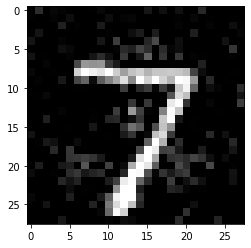

In [16]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [17]:
result=model.predict(best+x_test[0].reshape(1,784))
result[0]

array([4.2093713e-03, 1.4194575e-03, 1.4262672e-01, 5.5272180e-01,
       1.4619608e-04, 1.3698938e-02, 3.1703385e-05, 2.7359915e-01,
       8.2627973e-03, 3.2839691e-03], dtype=float32)

In [18]:
# test
count = 0
for i in range(784):
    if best[i] != 0:
        count+=1
print(count)

475


In [20]:
# test
count = 0
for i in range(784):
    if best[i] > 0.8:
        count+=1
print(count)

0


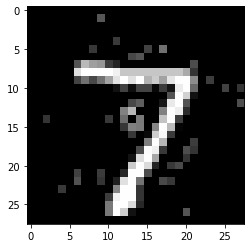

置信度： 0.8424834
[9.1767003e-04 5.8428705e-04 2.4540629e-02 1.1919443e-01 1.4927115e-04
 3.8930741e-03 9.9716972e-06 8.4248340e-01 3.5998647e-03 4.6274536e-03]
扰动程度： 4.396774529883714


In [15]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(best)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

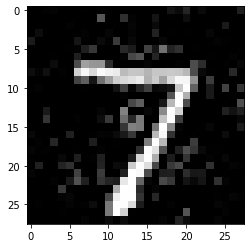

置信度： 0.50022095
[3.2277417e-03 1.2880706e-03 8.8591658e-02 3.8037843e-01 2.6989231e-04
 1.2227084e-02 2.4959374e-05 5.0022095e-01 8.8544004e-03 4.9166912e-03]
扰动程度： 5.342238182231904


In [20]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(best)
for i in range(784):
    if abs(x_F[i]) > 0.6:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.84129864


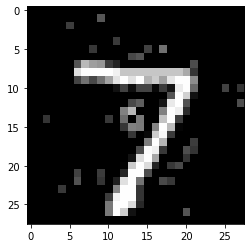

迭代: 2
置信度： 0.841192


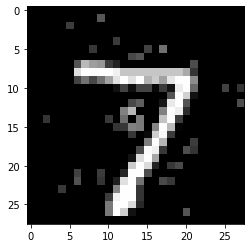

迭代: 3
置信度： 0.83890784


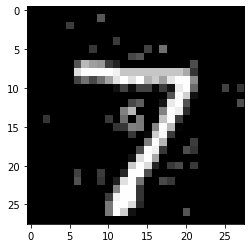

迭代: 4
置信度： 0.83617216


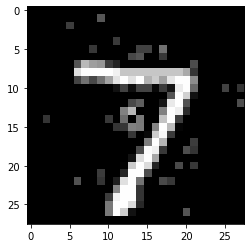

迭代: 5
置信度： 0.8350074


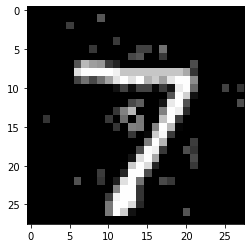

迭代: 6
置信度： 0.83116496


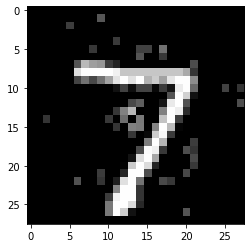

迭代: 7
置信度： 0.830711


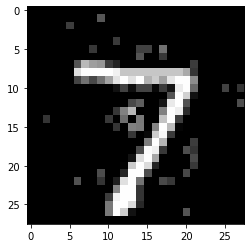

迭代: 8
置信度： 0.83026624


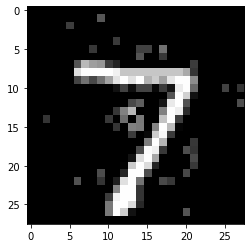

迭代: 9
置信度： 0.828436


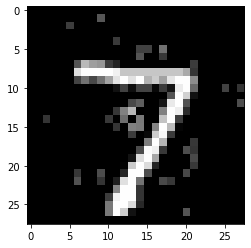

迭代: 10
置信度： 0.8282943


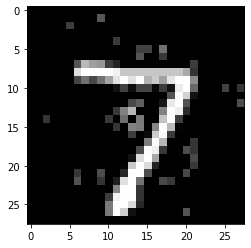

迭代: 11
置信度： 0.82604474


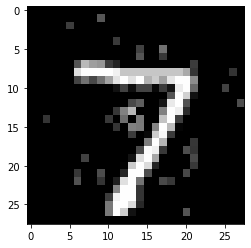

迭代: 12
置信度： 0.8249944


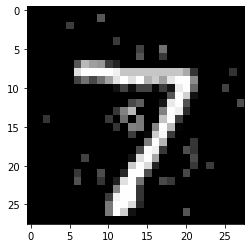

迭代: 13
置信度： 0.82432306


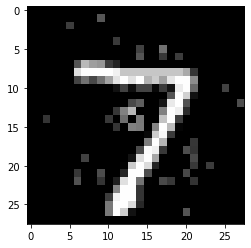

迭代: 14
置信度： 0.8240062


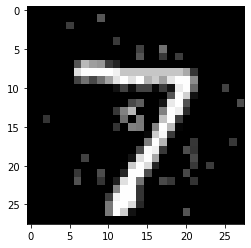

迭代: 15
置信度： 0.8228874


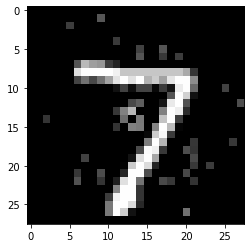

迭代: 16
置信度： 0.8202427


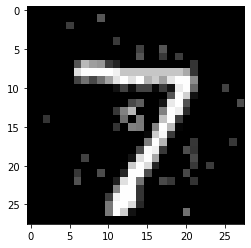

迭代: 17
置信度： 0.8156962


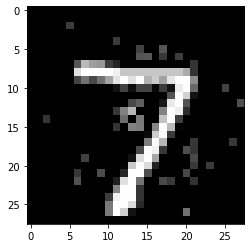

迭代: 18
置信度： 0.815118


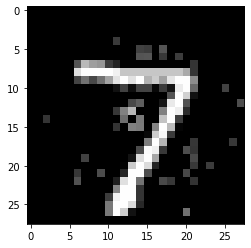

迭代: 19
置信度： 0.814871


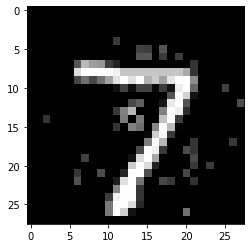

迭代: 20
置信度： 0.8114601


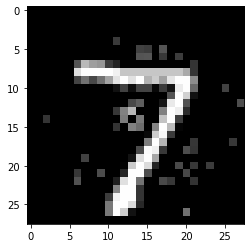

迭代: 21
置信度： 0.81128335


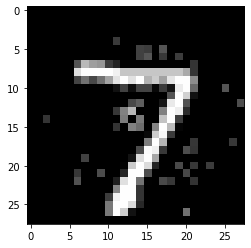

迭代: 22
置信度： 0.81112087


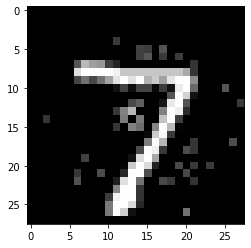

迭代: 23
置信度： 0.810064


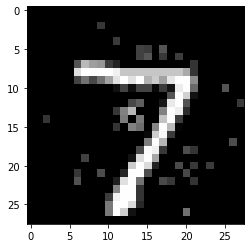

迭代: 24
置信度： 0.8041851


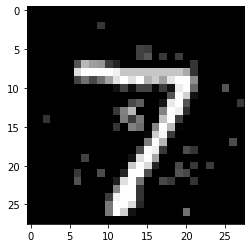

迭代: 25
置信度： 0.8022935


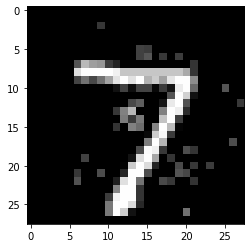

迭代: 26
置信度： 0.7984404


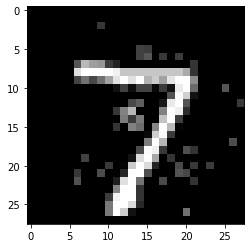

迭代: 27
置信度： 0.79821974


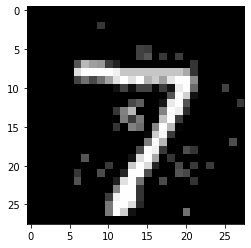

迭代: 28
置信度： 0.79584324


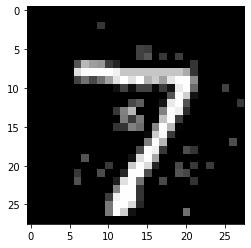

迭代: 29
置信度： 0.794954


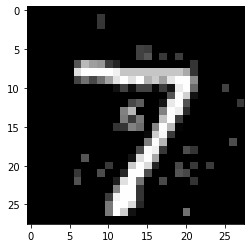

迭代: 30
置信度： 0.79467165


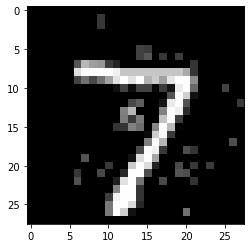

迭代失败


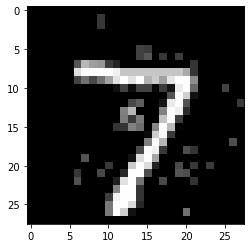

最终置信度： 0.79467165
最终扰动程度： 4.396774529883714
[1.2703206e-03 6.9075561e-04 3.4616861e-02 1.5130623e-01 1.5710102e-04
 4.6935016e-03 1.3530412e-05 7.9467165e-01 5.7824198e-03 6.7976140e-03]


In [21]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


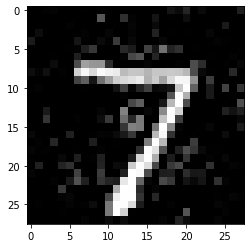

最终置信度： 0.50022095
最终扰动程度： 5.342238182231904
[3.2277417e-03 1.2880706e-03 8.8591658e-02 3.8037843e-01 2.6989231e-04
 1.2227084e-02 2.4959374e-05 5.0022095e-01 8.8544004e-03 4.9166912e-03]


In [22]:
# 改变坐标减小置信度（过滤0.6）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


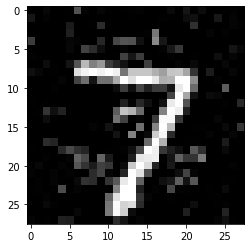

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])